# Branch Creation for Parallel Node Execution

- Author: [seofield](https://github.com/seofield)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

Parallel execution of nodes is essential for improving the overall performance of graph-based workflows. LangGraph provides native support for parallel node execution, significantly enhancing the efficiency of workflows built with this framework.

This parallelization is achieved using **fan-out** and **fan-in** mechanisms, utilizing both standard edges and `conditional_edges`.

![branching-graph](./assets/11-langgraph-branching-graph.png)

### Table of Contents

- [Overview](#overview)
- [Parallel Node Fan-out and Fan-in](#parallel-node-fan-out-and-fan-in)
- [Fan-out and Fan-in of Parallel Nodes with Additional Steps](#fan-out-and-fan-in-of-parallel-nodes-with-additional-steps)
- [Conditional Branching](#conditional-branching)
- [Sorting Based on Reliability of Fan-out Values](#sorting-based-on-reliability-of-fan-out-values)

### References

- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "false",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "",  # set the project name same as the title
        }
    )

Environment variables have been set successfully.


## Parallel Node Fan-out and Fan-in

**Fan-out / Fan-in**

In parallel processing, **fan-out** and **fan-in** describe the processes of dividing and consolidating tasks.

- **Fan-out (Expansion)**: A large task is divided into smaller, more manageable tasks. For example, when making a pizza, the dough, sauce, and cheese can be prepared independently. Dividing tasks to process them simultaneously is fan-out.

- **Fan-in (Consolidation)**: The divided smaller tasks are brought together to complete the overall task. Just like assembling the prepared ingredients to create a finished pizza, fan-in collects the results of parallel tasks to finalize the process.

In essence, **fan-out** distributes tasks, and **fan-in** gathers the results to produce the final output.


This example illustrates a fan-out from `Node A` to `Node B` and `Node C`, followed by a fan-in to `Node D`.

In the **State**, the `reducer(add)` operator is specified. This ensures that instead of simply overwriting existing values for a specific key in the State, the values are combined or accumulated. For lists, this means appending the new list to the existing one.

LangGraph uses the `Annotated` type to specify reducer functions for specific keys in the State. This approach allows attaching a reducer function (e.g., `add`) to the type without changing the original type (e.g., `list`) while maintaining compatibility with type checking.

In [4]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# Define State (using add_messages reducer)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# Class for returning node values
class ReturnNodeValue:
    # Initialization
    def __init__(self, node_secret: str):
        self._value = node_secret

    # Updates the state when called
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# Initialize the state graph
builder = StateGraph(State)

# Create nodes A through D and assign values
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Connect the nodes
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# Compile the graph
graph = builder.compile()

Let's visualize the graph.

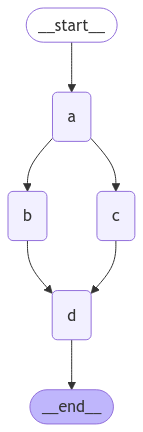

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

You can observe that the values added by each node are **accumulated** through the `reducer`.

In [6]:
# Execute the Graph
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='04834ec3-a39e-4713-9662-12bda90f5acf')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='04834ec3-a39e-4713-9662-12bda90f5acf')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='04834ec3-a39e-4713-9662-12bda90f5acf'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='54171388-7830-40a2-b130-46c4d0d0b38b'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='9887bbbc-e0d3-4e5e-8e52-a6201e044ad2')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='04834ec3-a39e-4713-9662-12bda90f5acf'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='54171388-7830-40a2-b130-46c4d0d0b38b'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='9887bbbc-e0d3-4e5e-8e52-a6201e044ad2'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='acd59483-71f2-416d-8ec6-65be0cee82ea')]}

### Handling Exceptions during Parallel Processing

LangGraph executes nodes within a "superstep". This means that even if parallel branches are executed simultaneously, the entire superstep is processed in a **transactional** manner.

> **Superstep**: A complete processing step involving multiple nodes.

As a result, if an exception occurs in any of the branches, **no updates** are applied to the state (the entire superstep is rolled back).

![branching-graph](./assets/11-langgraph-branching-graph.png)

For tasks prone to errors (e.g., handling unreliable API calls), LangGraph offers two solutions:

1. You can write standard Python code within nodes to catch and handle exceptions directly.
2. Set up a **[retry_policy](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy)** to instruct the graph to retry nodes that encounter specific types of exceptions. Only the failed branches are retried, so you don’t need to worry about unnecessary reprocessing.

These features enable complete control over parallel execution and exception handling.

## Fan-out and Fan-in of Parallel Nodes with Additional Steps

The previous example demonstrated how to perform `fan-out` and `fan-in` when each path consists of a single step. But what happens when a path contains multiple steps?

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# Define State (using add_messages reducer)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# Class for returning node values
class ReturnNodeValue:
    # Initialization
    def __init__(self, node_secret: str):
        self._value = node_secret

    # Updates the state when called
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# Initialize the state graph
builder = StateGraph(State)

# Create and connect nodes
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

# Compile the graph
graph = builder.compile()

Let's visualize the graph.

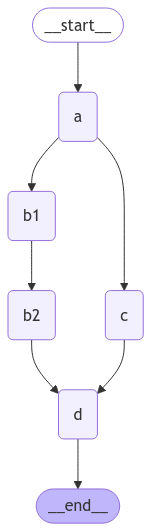

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Execute Graph Aggregation with an Empty List, perform a basic aggregation operation across all data using an empty list as the initial state.
graph.invoke({"aggregate": []})


Adding I'm A to []
Adding I'm B1 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e0e0b30d-2611-41ec-a735-0e8835b45205')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e0e0b30d-2611-41ec-a735-0e8835b45205')]
Adding I'm B2 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e0e0b30d-2611-41ec-a735-0e8835b45205'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='00c18d89-67b8-4163-9783-7e20bfb73059'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='30287806-99a5-4d83-96d5-5c350bc618a8')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e0e0b30d-2611-41ec-a735-0e8835b45205'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='00c18d89-67b8-4163-9783-7e20bfb73059'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='30287

{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e0e0b30d-2611-41ec-a735-0e8835b45205'),
  HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='00c18d89-67b8-4163-9783-7e20bfb73059'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='30287806-99a5-4d83-96d5-5c350bc618a8'),
  HumanMessage(content="I'm B2", additional_kwargs={}, response_metadata={}, id='36d71515-3960-48ee-ab9a-e4482c33090f'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='c3c583c6-a496-4f39-a112-c90d41849fa1')]}

## Conditional Branching

When the fan-out is non-deterministic, you can directly use `add_conditional_edges`.

In [10]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages


# Define State (using add_messages reducer)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str


# Class for returning unique values per node
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# Initialize the state graph
builder = StateGraph(State)

# Define nodes and connect them
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


# Define the routing logic based on the 'which' value in the state
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# List of nodes to process in parallel
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)

for node in intermediates:
    builder.add_edge(node, "e")


# Connect the final node and compile the graph
builder.add_edge("e", END)
graph = builder.compile()

If there is a known "sink" node to connect to after the conditional branching, you can specify `then="node_name_to_execute"` when creating the conditional edge.

Here is a reference code snippet. When using the `then` syntax, you can add `then="e"` and omit adding explicit edge connections.

In [2]:
## Using the `then` Syntax
# builder.add_conditional_edges(
#     "a",
#     route_bc_or_cd,
#     intermediates,
#     then="e",
# )

Let's visualize the graph.

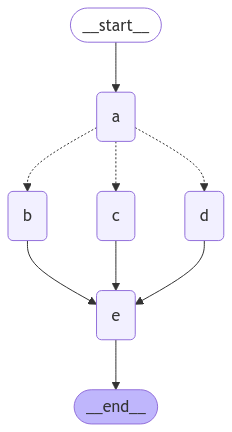

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# Execute the Graph (set `which`:`bc`)
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='da51b3ce-e49c-422f-aac1-ac1a4c620a50')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='da51b3ce-e49c-422f-aac1-ac1a4c620a50')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='da51b3ce-e49c-422f-aac1-ac1a4c620a50'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='4da170a0-c01d-476c-807f-5de7307aafcc'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='c43a6e78-7096-44ae-9041-2a9e5278db68')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='da51b3ce-e49c-422f-aac1-ac1a4c620a50'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='4da170a0-c01d-476c-807f-5de7307aafcc'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='c43a6e78-7096-44ae-9041-2a9e5278db68'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='9976cd5c-dfdf-412d-8a50-833d26c864bd')],
 'which': 'bc'}

In [14]:
# Execute the Graph (set `which`:`cd`)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='f19f377c-03a3-43ca-9abc-755babeada1d')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='f19f377c-03a3-43ca-9abc-755babeada1d')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='f19f377c-03a3-43ca-9abc-755babeada1d'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='cbadef64-f5ac-414f-89bd-d7de7fbf8f36'), HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='285ae8b7-7b9b-4076-b3b1-35ce66a62ef1')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='f19f377c-03a3-43ca-9abc-755babeada1d'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='cbadef64-f5ac-414f-89bd-d7de7fbf8f36'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='285ae8b7-7b9b-4076-b3b1-35ce66a62ef1'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='8abc9b73-6fe8-42a7-b04b-aa30a25fbd4b')],
 'which': 'cd'}

## Sorting Based on Reliability of Fan-out Values

Nodes spread out in parallel are executed as part of a single "**super-step**". Updates from each super-step are sequentially applied to the state only after the super-step is completed.

If a consistent, predefined order of updates is required during a parallel super-step, the output values can be recorded in a separate field of the state with an identifying key. Then, use standard `edges` from each fan-out node to the convergence point, where a "sink" node combines these outputs.

For example, consider a scenario where you want to sort the outputs of parallel steps based on their "reliability".

In [15]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# Logic to merge fan-out values, handle empty lists, and concatenate lists
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # Overwrite
        return []
    return left + right


# Type definition for state management, configuring structures for aggregation and fan-out values
class State(TypedDict):
    # Use the add_messages reducer
    aggregate: Annotated[list, add_messages]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


# Initialize the graph
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


# Class for returning parallel node values
class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    # Update the state when called
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


# Add parallel nodes with different reliability values
builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.1))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.9))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.5))


# Aggregate fan-out values based on reliability and perform final aggregation
def aggregate_fanout_values(state: State) -> Any:
    # Sort by reliability
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    print(ranked_values)
    return {
        "aggregate": [x["value"][0] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


# Add aggregation node
builder.add_node("e", aggregate_fanout_values)


# Define conditional routing logic based on state
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# Configure intermediate nodes and add conditional edges
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

# Connect intermediate nodes to the final aggregation node
for node in intermediates:
    builder.add_edge(node, "e")

# Finalize the graph
graph = builder.compile()

Let's visualize the graph.

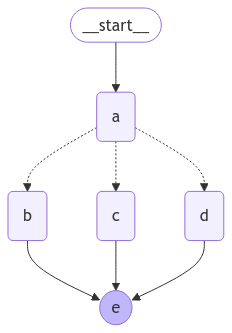

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

The results from executing nodes in parallel are then sorted based on their reliability.

**Reference**

- `b`: reliability = 0.1  
- `c`: reliability = 0.9  
- `d`: reliability = 0.5

In [17]:
# Execute the Graph (set `which`:`bc`)
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ecf02c68-88bc-469c-b863-182e4daec1bc')] in parallel.
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ecf02c68-88bc-469c-b863-182e4daec1bc')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm B"], 'reliability': 0.1}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ecf02c68-88bc-469c-b863-182e4daec1bc'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='a4f32e94-2ff9-43a1-8ae0-e6237979fa5d'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='e6e20712-91e8-44b2-bb25-9321822d6260'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='8972efe5-ef49-429a-ab8b-bf08e5487822')],
 'fanout_values': [],
 'which': 'bc'}

In [18]:
# Execute the Graph (set `which`:`cd`)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='44beec0c-8fd5-469f-a705-1101fe4e422a')] in parallel.
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='44beec0c-8fd5-469f-a705-1101fe4e422a')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm D"], 'reliability': 0.5}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='44beec0c-8fd5-469f-a705-1101fe4e422a'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='37cf7718-673c-44ae-912d-f2b92c267faf'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='6204397b-8bed-4c68-afe0-a5dfd7140aea'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='588c2b73-b994-44a2-aa5a-d66bac8bacbd')],
 'fanout_values': [],
 'which': 'cd'}